I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
training_file = '/u/ki/swmclau2/des/wt_trainer2/PearceRedMagicChinchillaWT.hdf5'
#training_file = '/u/ki/swmclau2/des/ds_trainer3/PearceRedMagicChindhillaDS.hdf5'


em_method = 'gp'
split_method = 'random'

In [5]:
a = 0.81120
z = 1.0/a - 1.0


In [6]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [7]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params, independent_variable=None,\
                     custom_mean_function = "linear", downsample_factor = 1.0)

In [8]:
emu.get_param_names()

['logM1', 'logMmin', 'f_c', 'logM0', 'sigma_logM', 'alpha', 'r']

In [9]:
%%bash
ls /u/ki/swmclau2/des/PearceMCMC/*wtheta*hyperparams.npy

/u/ki/swmclau2/des/PearceMCMC/100_walkers_100_steps_wtheta_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_alt_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_exp2_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_matern32_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_matern52_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_200_steps_wtheta_alt_hyperparams.npy
/u/ki/swmclau2/des/PearceMCMC/200_walkers_200_steps_wtheta_hyperparams.npy


In [10]:
chain = np.genfromtxt('/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_matern32_hyperparams.npy')

In [11]:
chain.shape[0]

16800

In [12]:
chain = np.genfromtxt('/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_exp2_hyperparams.npy')
#chain = np.genfromtxt('/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_delta_sigma_exp2_hyperparams.npy')

#v = chain.mean(axis = 0)
n_burn =  0
v = chain[200*n_burn:,].mean(axis = 0)

In [13]:
print dict(zip(emu.get_param_names(), np.exp(v[2:])) )
#print emu._emulator.kernel

{'logMmin': 3.2496991210194732, 'f_c': 6.5225471765230409, 'logM0': 0.90031876392525889, 'logM1': 5.7115389793138123, 'r': 0.85251205183917733, 'sigma_logM': 81.17344472376017, 'alpha': 156.63415402538018}


In [14]:
emu.obs

'wt'

In [15]:
params = {}
#params['mean_occupation_centrals_assembias_param1'] = 0
#params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 13.2
params['sigma_logM'] = 0.2
params['f_c'] = 0.25
params['alpha'] = 1.1
params['logM1'] = 14.5
params['logM0'] = 15.5
#params['z'] = 0.5
print params

{'logMmin': 13.2, 'f_c': 0.25, 'logM0': 15.5, 'logM1': 14.5, 'sigma_logM': 0.2, 'alpha': 1.1}


In [16]:
l = len(emu.scale_bin_centers)
idx = 15
params = {pname:pval for pname, pval in zip(emu._ordered_params.iterkeys(), emu.x[idx*l,:-1]*emu._x_std[:-1] + emu._x_mean[:-1])}

In [17]:
for k,_v in params.iteritems():
    print k,'\t'*5,_v

logMmin 					12.1100271397
f_c 					0.391101498903
logM0 					14.3252283948
logM1 					14.3212173935
sigma_logM 					0.0938050332533
alpha 					1.07747077502


In [18]:
sc_inv = 0.0001239041803415539
W = 0.00275848072207

In [19]:
print emu.x.shape

(20000, 7)


In [20]:
#mean_line = np.zeros((l,))#
mean_line = emu.mean_function(emu.x[(idx)*l:(idx+1)*l, :])

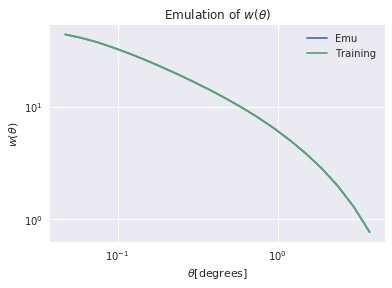

In [21]:
#param_name = 'logMmin'
#bounds = emu.get_param_bounds(param_name)
#vals = np.linspace(bounds[0], bounds[1], 4)
#for v in vals:
    #params[param_name] = v
wt = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
plt.plot(emu.scale_bin_centers, 10**wt, label = 'Emu') #label = '%s=%.2f'%(param_name, v) )

plt.plot(emu.scale_bin_centers, 10**(emu.y[(idx)*l:(idx+1)*l] + mean_line ), label = 'Training')
#plt.plot(emu.scale_bin_centers, wt_redmagic, label = 'RedMagic')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'Emulation of $w(\theta)$')# w.r.t. %s'%param_name)

In [22]:
from sklearn.model_selection import train_test_split
x, y, yerr = emu.x, emu.y, emu.yerr
#downsample_idxs = np.random.choice(x.shape[0], size = int(x.shape[0]), replace = False)
#x,y, yerr = x[downsample_idxs, :], y[downsample_idxs], yerr[downsample_idxs]
test_size = 0.05

n_points = y.shape[0]/len(emu.scale_bin_centers)
n_test_points = int(n_points*(1-test_size))*len(emu.scale_bin_centers)

train_x, test_x, train_y, test_y, train_yerr, test_yerr = emu.x[:n_test_points], emu.x[n_test_points:],\
                                                          emu.y[:n_test_points], emu.y[n_test_points:],\
                                                          emu.yerr[:n_test_points], emu.yerr[n_test_points:]


#train_x, test_x, train_y, test_y, train_yerr, test_yerr = train_test_split(x, y, yerr, test_size = 0.1)
#train_x, test_x, train_y, test_y, train_yerr, test_yerr = emu.x, emu.x, emu.y, emu.y, emu.yerr, emu.yerr

In [23]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [24]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean

In [25]:
pred_y+= emu.mean_function(test_x)
test_y+= emu.mean_function(test_x)

In [26]:
pred_y.shape, test_y.shape

((1000,), (1000,))

In [27]:
from seaborn import jointplot

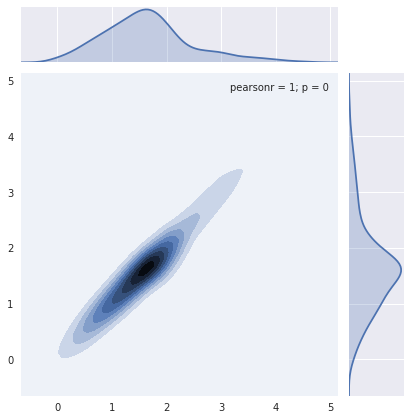

In [28]:
sns.jointplot(pred_y, test_y, kind = 'kde')


In [29]:
idxs =  np.argsort(np.abs((10**pred_y-10**test_y)/10**test_y))

In [30]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

0.12177085273087232

In [31]:
np.mean(np.abs((10**pred_y-10**test_y)/(10**test_y)))

0.083290163031070966

In [32]:
np.median(np.abs((10**pred_y-10**test_y)/(10**test_y)))

0.02985283992753094

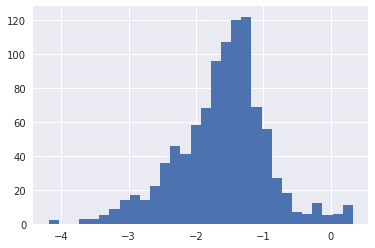

In [33]:
plt.hist(np.log10(np.abs((10**pred_y-10**test_y)/10**test_y)), bins = 30);